### Functions

In [1]:
cd '/h/ama/workspace/ama-at-vector/Co-Mixup-master'

/scratch/ssd001/home/ama/workspace/ama-at-vector/Co-Mixup-master


In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import math
from match import get_onehot_matrix, mix_input
import pickle

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [5]:
def print_fig(input, target=None, title=None, save_dir=None):
    fig, axes = plt.subplots(1,len(input),figsize=(3*len(input),3))
    if title:
        fig.suptitle(title, size=16)
    if len(input) == 1 :
        axes = [axes]
        
    for i, ax in enumerate(axes):
        if len(input.shape) == 4:
            ax.imshow(input[i].permute(1,2,0).numpy())
        else :
            ax.imshow(input[i].numpy(), cmap='gray', vmin=0., vmax=1.)
        
        if target is not None:
            output = net((input[i].unsqueeze(0) - mean)/std)
            loss = criterion(output, target[i:i+1])
            ax.set_title("loss: {:.3f}\n pred: {}\n true : {}".format(loss, CIFAR100_LABELS_LIST[output.max(1)[1][0]], CIFAR100_LABELS_LIST[target[i]]))
        ax.axis('off')
    plt.subplots_adjust(wspace = 0.1)
    
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches = 'tight',  pad_inches = 0)
        
    plt.show()
     
def to_one_hot(inp, num_classes, device='cpu'):
    '''one-hot label'''
    y_onehot = torch.zeros((inp.size(0), num_classes), dtype=torch.float32, device=device)
    y_onehot.scatter_(1, inp.unsqueeze(1), 1)
    return y_onehot

### Input Images

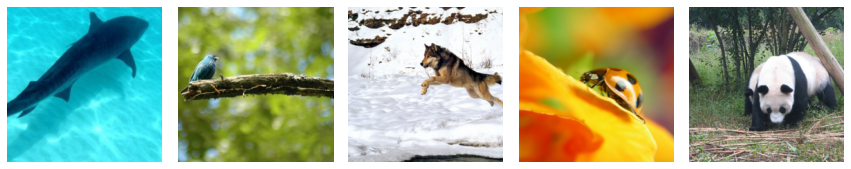

In [13]:
resnet = models.resnet18(pretrained=True)
resnet.eval()

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
mean_torch = mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
std_torch = std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

test_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std)])

n_input=5

with open('/h/ama/workspace/ama-at-vector/best-mix/figures/sample.data', 'rb') as file:
    input_sp, targets = pickle.load(file)


criterion = nn.CrossEntropyLoss()
bce_loss = nn.BCELoss()
softmax = nn.Softmax(dim=1)

'''Selected inputs for visualization'''
# indices = [(356, 2), (948, 5), (852, 2), (3, 1), (1, 19), (3,27), (11,9), (11,20), (11,45), (14,29), (162, 7), (167,3), (167,41),
#           (215, 6),  (215, 11), (215, 23), (215, 24), (215, 40), (240, 34), (240, 49), (269,21), (269, 37), (301,0), (388,19)]
# inputs = torch.stack([val_dset[idx[0]*50 + idx[1]][0] for idx in indices], dim=0)
# targets = torch.tensor([idx[0] for idx in indices])
target_onehot = to_one_hot(targets, num_classes=1000)
           
'''Calculate saliency'''
input_var = input_sp.clone().detach().requires_grad_(True)
output = resnet(input_var)
# loss = criterion(output, targets)
loss = bce_loss(softmax(output), target_onehot)
loss.backward()

unary = torch.sqrt(torch.mean(input_var.grad **2, dim=1))  
unary = unary / unary.view(n_input, -1).max(1)[0].view(n_input, 1, 1)

unary16 = F.avg_pool2d(unary, 224//16)
unary16 = unary16 / unary16.view(n_input, -1).max(1)[0].view(n_input, 1, 1)
    
print_width = 5
for i in range(n_input // print_width):
    print_fig((input_sp * std_torch + mean_torch)[print_width*i: print_width*(i+1)])

#### Co-Mixup Outputs
large beta => more smooth boundary data   
large thres (tau in paper) => more inputs are mixed per output

#### Co-Mixup Outputs (Higher tau, i.e., more input sources per output)

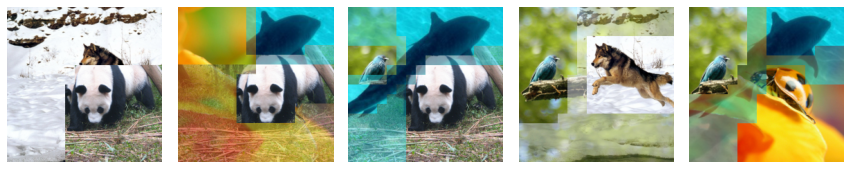

In [16]:
beta = 2.0
gamma = 1.0
thres = 0.86
cost_matrix = - unary16 / unary16.view(n_input, -1).sum(-1).view(n_input, 1, 1)
for k in [0,]:
    np.random.seed(k)
    A = torch.eye((n_input))
    mask_onehot = get_onehot_matrix(cost_matrix, A, n_output, beta=beta, gamma=gamma, eta=0.0, thres=thres, device='cpu')    
    outputs, target_reweighted = mix_input(mask_onehot, input_sp, target_onehot)
    for i in range(n_input // print_width):
        print_fig((outputs * std_torch + mean_torch)[print_width*i: print_width*(i+1)])

    print("="*100)